C题附件2预测


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller  # 单位根检验
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox  # 白噪声检验

# 绘图支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

data = pd.read_excel('C_附件2.xlsx')

t = pd.period_range('2017-2-1', periods=240, freq='w')
index = pd.PeriodIndex(t,freq='d')
data.index=index

ValueError: Length mismatch: Expected axis has 8 elements, new values have 240 elements

In [16]:
def get_pdq(dy_24):
    '模型定阶'
    
    p = q =range(0,2)
    d = range(0,2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0],x[1],x[2],24) for x in list(itertools.product(p,d,q))]
    out = []
    for param in pdq:
        for ps in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(dy_24,
                                               order=param,
                                               seasonal_order=ps,
                                               enforce_stationarity=False,
                                               enforce_invertibility=False)
                results = mod.fit()
#                 print('ARIMA{}*{} - AIC:{}'.format(param,ps,results.aic))
                out.append([param,ps,results.aic])
            except:
                continue
    return out

def forecast_y(par,dy):
    '预测'
    aic = pd.DataFrame([x[2] for x in par])
    i = aic.idxmin().loc[0]
    order = par[i][0]
    seasonal_order = par[i][1]
    mod = sm.tsa.statespace.SARIMAX(dy,
                                               order=order,
                                               seasonal_order=seasonal_order,
                                               enforce_stationarity=False,
                                               enforce_invertibility=False)
    results = mod.fit()
    pre = results.predict()
    forecast = results.forecast(24)
    return forecast,pre

In [62]:
# 预测24周的转运商损耗
out = pd.DataFrame()
fore_out=pd.DataFrame()

for n in range(data.T.shape[1]):  # data.T.shape[1]
    print('正在预测第 {} 个转运商的损耗率,请稍候...'.format(n+1),end='    ')
    y = data.T.iloc[1:,n]
    dy_24 = y.diff(24).dropna().astype('float')
    
    # 模型定阶
    par = get_pdq(dy_24)
    
    aic = pd.DataFrame([x[2] for x in par])
    i = aic.idxmin().loc[0]
    order = par[i][0]
    seasonal_order = par[i][1]
    print(' --> 最优预测模型为：ARIMA{}*{}'.format(order,seasonal_order))
    
    # 向后预测24周
    fore,pre=forecast_y(par,dy_24)
    
    #还原数据
    t = pd.period_range('2021-9-12', periods=24, freq='w')
    index = pd.PeriodIndex(t,freq='d')
    fore.index = index
    tem = y[-24:].copy()
    tem.index = index
#     y = data2_T.iloc[:,n]
#     forecast =pd.concat([y,fore+tem])
#     plt.figure(figsize=[16,6])
#     plt.plot(forecast.dropna(),'g')
#     plt.plot(y,'r')
#     plt.show()
    te = fore.astype('float')+tem
    te[te<0]=0
    new_y = pd.concat([y.shift(24).dropna().astype('float')+pre.astype('float'),te],axis=0)
    new_y[new_y<0]=0
    
    out['T'+str(n+1).zfill(3)] = te
    fore_out['T'+str(n+1).zfill(3)] = new_y
    
out.index = ['第'+ str(i+1).zfill(2) + '周' for i in range(24)]
out.T.to_excel('转运商预测结果_24周.xlsx')

fore_out.index = ['第'+ str(i+25).zfill(2) + '周' for i in range(240)]
fore_out.T.to_excel('转运商预测结果_全部.xlsx')

正在预测第 1 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 0)*(0, 0, 1, 24)
正在预测第 2 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(0, 1, 1)*(1, 0, 1, 24)
正在预测第 3 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 4 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(0, 0, 1, 24)
正在预测第 5 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 1, 1, 24)
正在预测第 6 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 0)*(0, 0, 0, 24)
正在预测第 7 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(1, 1, 1)*(0, 0, 1, 24)
正在预测第 8 个转运商的损耗率,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 0)*(0, 0, 1, 24)


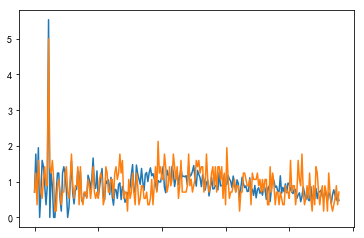

In [61]:
fore_out.iloc[:,1].plot()
data.T.iloc[1:,1].plot()

In [56]:
y.shift(24).dropna()+pre

W025         0.7092
W026          1.773
W027         0.5319
W028         1.9503
W029    1.86286e-07
W030         0.7092
W031         1.5957
W032         1.4184
W033         0.8865
W034         0.3546
W035         0.8865
W036         5.5319
W037         -3.227
W038         1.2411
W039         0.8865
W040        -0.1773
W041        -0.1773
W042         0.7092
W043         1.2411
W044         1.2411
W045         0.5319
W046         0.1773
W047         1.2411
W048         1.4184
W049        1.20591
W050       0.756115
W051     -0.0234579
W052       0.266506
W053       0.929526
W054         1.5796
           ...     
W211       0.784649
W212        1.16187
W213        1.01495
W214       0.843028
W215       0.876173
W216       0.733925
W217       0.717735
W218        1.16413
W219       0.676682
W220       0.842316
W221       0.713059
W222       0.938839
W223       0.690095
W224       0.961591
W225       0.940425
W226       0.782962
W227       0.705902
W228       0.667346
W229       0.804335
